In [254]:
using Revise

includet("./modules/RidgeRegression.jl")
includet("./modules/Experiments.jl")
includet("./modules/Replica.jl")

using .RidgeRegression: solve_rr
using .Experiments: generate_data, convert_to_vec, calc_generalization_error, calc_orderparams
using .Replica: solve_replica

using Distributions, Random, Statistics, CairoMakie, LinearAlgebra


In [255]:
τ = 2.6
κ = 0.4
σ = 0.01
λ = 0.0
α = 1800000.0
α_tilde = 8.0
ρs = range(0.01, 1.0, length=1000)
σ_test = 0.0;
γ = τ / κ

6.5

In [256]:
ms = zeros(length(ρs))
m_bars = zeros(length(ρs))
m_hats = zeros(length(ρs))
m0s = zeros(length(ρs))

qs = zeros(length(ρs))
q_hat_bars = zeros(length(ρs))
q_hats = zeros(length(ρs))
q_bars = zeros(length(ρs))
q0s = zeros(length(ρs))

chi_hat_bars = zeros(length(ρs))
chi_hats = zeros(length(ρs))
chi_bars = zeros(length(ρs))
chis = zeros(length(ρs))


for (i, ρ) in enumerate(ρs)
    q, m, χ, q_bar, χ_bar, q̂, m̂, χ̂, q̂_bar, χ̂_bar, m_bar, q0, m0 = solve_replica(α, τ, κ, λ, σ, ρ)
    ms[i] = m
    m_bars[i] = m_bar
    m_hats[i] = m̂
    m0s[i] = m0

    qs[i] = q
    q_bars[i] = q_bar
    q_hat_bars[i] = q̂_bar
    q_hats[i] = q̂
    q0s[i] = q0

    chi_hats[i] = χ̂
    chi_hat_bars[i] = χ̂_bar    
    chi_bars[i] = χ_bar
    chis[i] = χ
end


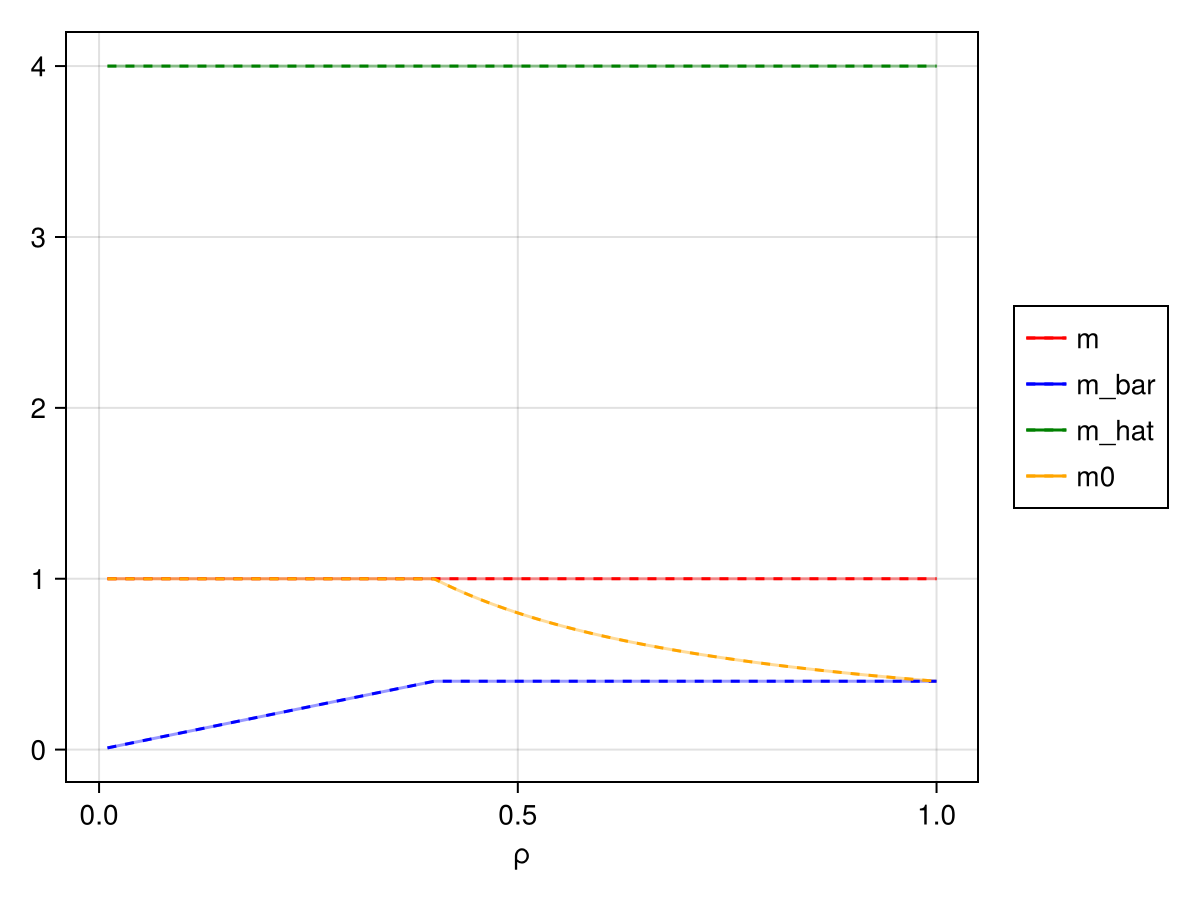

CairoMakie.Screen{IMAGE}


In [ ]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="ρ")
colors = ["red", "blue", "green", "orange", "purple", "brown"]
lines!(ax, ρs, ms, label="m", color=colors[1], alpha=0.4)
lines!(ax, ρs, m_bars, label="m_bar", color=colors[2], alpha=0.4)
lines!(ax, ρs, m_hats, label="m_hat", color=colors[3], alpha=0.4)
lines!(ax, ρs, m0s, label="m0", color=colors[4], alpha=0.4)

lines!(ax, ρs, fill(1.0, length(ρs)), label="m", color=colors[1], linestyle=:dash)
lines!(ax, ρs, min.(ρs, κ), label="m_bar", color=colors[2], linestyle=:dash)
lines!(ax, ρs, fill((τ-1)/κ, length(ρs)), label="m_hat", color=colors[3], linestyle=:dash)
lines!(ax, ρs, min.(ρs, κ) ./ ρs, label="m0", color=colors[4], linestyle=:dash)
Legend(fig[1, 2], ax, merge=true)
display(fig)

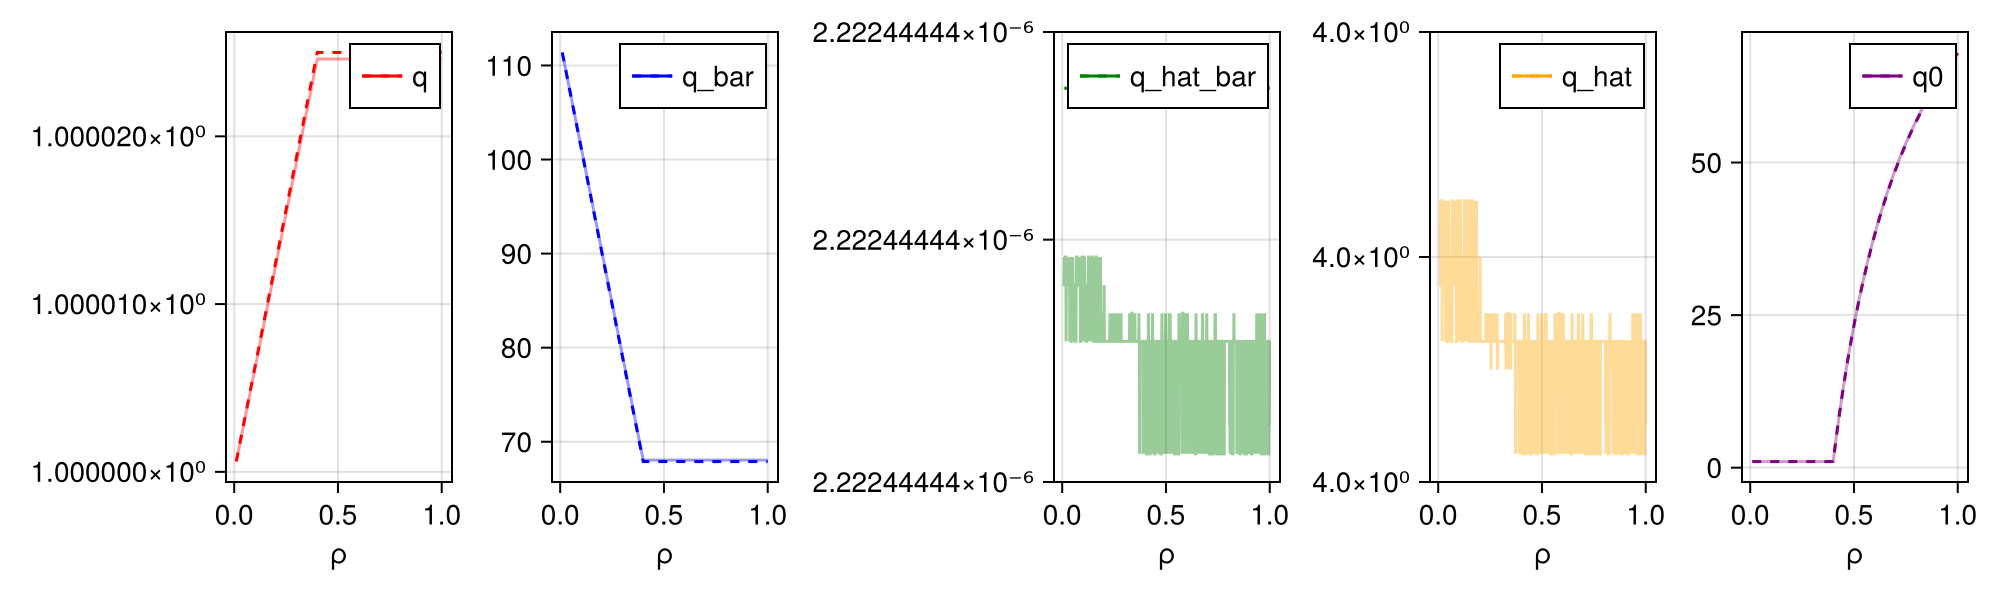

CairoMakie.Screen{IMAGE}


In [258]:
fig = Figure(size=(1000, 300))
ax1 = Axis(fig[1, 1], xlabel="ρ")
ax2 = Axis(fig[1, 2], xlabel="ρ")
ax3 = Axis(fig[1, 3], xlabel="ρ")
ax4 = Axis(fig[1, 4], xlabel="ρ")
ax5 = Axis(fig[1, 5], xlabel="ρ")
colors = ["red", "blue", "green", "orange", "purple", "brown"]
lines!(ax1, ρs, qs, label="q", color=colors[1], alpha=0.4)
lines!(ax2, ρs, q_bars, label="q_bar", color=colors[2], alpha=0.4)
lines!(ax3, ρs, q_hat_bars, label="q_hat_bar", color=colors[3], alpha=0.4)
lines!(ax4, ρs, q_hats, label="q_hat", color=colors[4], alpha=0.4)
lines!(ax5, ρs, q0s, label="q0", color=colors[5], alpha=0.4)

# 理論式に基づくdash線
# q = 1 + (σ^2)/(1-τ) * min(κ, ρ)
q_theory = 1 .- (σ^2)/(1-τ) .* min.(κ, ρs)
#q_theory = @. 1 + chi_hats * ρs / (κ * q_hats^2)
lines!(ax1, ρs, q_theory, label="q", color=colors[1], linestyle=:dash)

# q_bar = (σ^2)/(1+σ^2) * (1-min(κ,ρ))/(τ-1) * α
q_bar_theory = (σ^2)/(1+σ^2) .* (1 .- min.(κ, ρs))./(τ-1) .* α .+ min.(κ, ρs)
lines!(ax2, ρs, q_bar_theory, label="q_bar", color=colors[2], linestyle=:dash)

# q_hat_bar = (1+σ^2)/α * (τ-1)/κ
q_hat_bar_theory = (1+σ^2)/α .* (τ-1)/κ
lines!(ax3, ρs, fill(q_hat_bar_theory, length(ρs)), label="q_hat_bar", color=colors[3], linestyle=:dash)

# q_hat = (τ-1)/κ
q_hat_theory = fill((τ-1)/κ, length(ρs))
lines!(ax4, ρs, q_hat_theory, label="q_hat", color=colors[4], linestyle=:dash)
println(q_hat_theory)
println(q_hats)

# q0 = case分けの実装
q0_theory = zeros(length(ρs))
for (i, ρ) in enumerate(ρs)
    c = ρ  # cはρと仮定
    if c > κ
        q0_theory[i] = κ/ρ + (ρ-κ)/(ρ*(τ-1)) * (σ^2)/(1+σ^2) * α
    else  # c < κ
        q0_theory[i] = 1 + (σ^2)/(τ-1) * (κ*ρ)/(κ-ρ)
    end
end
lines!(ax5, ρs, q0_theory, label="q0", color=colors[5], linestyle=:dash)

axislegend(ax1, merge=true)
axislegend(ax2, merge=true)
axislegend(ax3, merge=true)
axislegend(ax4, merge=true)
axislegend(ax5, merge=true)
display(fig)

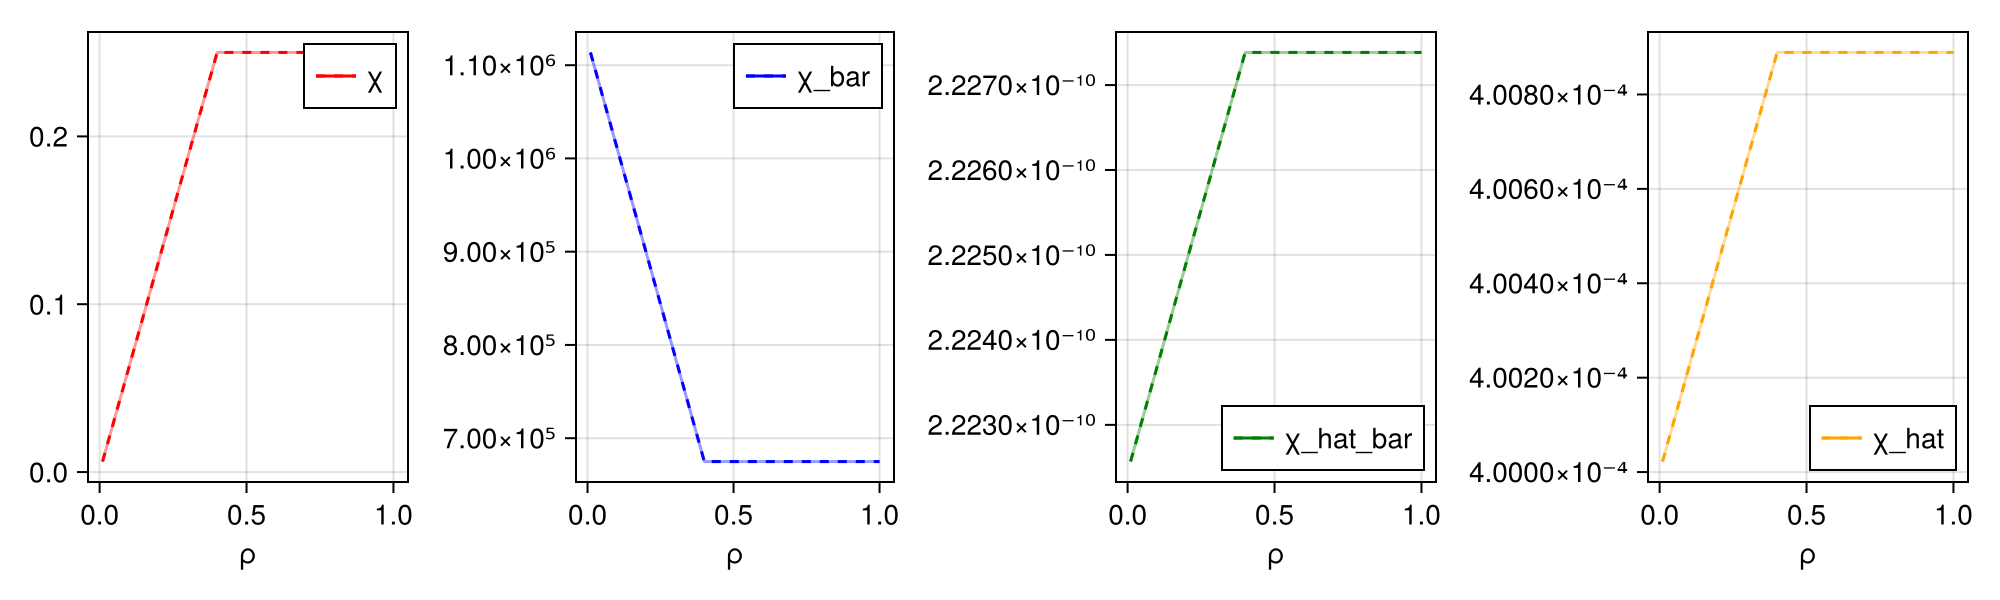

CairoMakie.Screen{IMAGE}


In [259]:
fig = Figure(size=(1000, 300))
ax1 = Axis(fig[1, 1], xlabel="ρ")
ax2 = Axis(fig[1, 2], xlabel="ρ")
ax3 = Axis(fig[1, 3], xlabel="ρ")
ax4 = Axis(fig[1, 4], xlabel="ρ")

colors = ["red", "blue", "green", "orange", "purple", "brown"]
lines!(ax1, ρs, chis, label="χ", color=colors[1], alpha=0.4)
lines!(ax2, ρs, chi_bars, label="χ_bar", color=colors[2], alpha=0.4)
lines!(ax3, ρs, chi_hat_bars, label="χ_hat_bar", color=colors[3], alpha=0.4)
lines!(ax4, ρs, chi_hats, label="χ_hat", color=colors[4], alpha=0.4)

# 理論式に基づくdash線
# χ = min(κ,ρ)/(τ-1)  
chi_theory = min.(κ, ρs)./(τ-1) 
lines!(ax1, ρs, chi_theory, label="χ", color=colors[1], linestyle=:dash)

# χ̄ = (1-min(κ,ρ))/(τ-1) * 1/(1+σ²) * α
chi_bar_theory = (1 .- min.(κ, ρs))./(τ-1) .* 1/(1+σ^2) * α
lines!(ax2, ρs, chi_bar_theory, label="χ_bar", color=colors[2], linestyle=:dash)



for i in 1:length(ρs)
    ρ = ρs[i]
    z = -(1+σ^2)/α
    const_term = (κ * (γ - 1/κ)^2 * σ^2) / (γ*κ - 1)

    if ρ < κ
        z_coeff = - (κ*ρ * (γ - 1/κ)^2) / (γ*κ - 1)
        chi_hat_theory[i] = const_term + z_coeff * z
        
    else
        z_coeff = - (κ^2 * (γ - 1/κ)^2) / (γ*κ - 1)
        chi_hat_theory[i] = const_term + z_coeff * z
    end
end
lines!(ax4, ρs, chi_hat_theory, label="χ_hat", color=colors[4], linestyle=:dash)




# χ̂̄_bar 
chi_hat_bar_theory = chi_hat_theory .* (1+σ^2) / α
lines!(ax3, ρs, chi_hat_bar_theory, label="χ_hat_bar", color=colors[3], linestyle=:dash)



axislegend(ax1, merge=true)
axislegend(ax2, merge=true)
axislegend(ax3, merge=true, position=:rb)
axislegend(ax4, merge=true, position=:rb)
display(fig)
